In [1]:
import numpy as np
import requests
from bs4 import BeautifulSoup
import time
import re
import pandas as pd
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from datetime import datetime
from sentence_transformers import SentenceTransformer, util
from nltk.tokenize import sent_tokenize
import torch
import nltk

c:\Users\boyu571\anaconda3\envs\commons\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
data = pd.read_csv(r'C:\Users\boyu571\boyu571_Github\01_Kakaobank_SKKU_Research_23\data\foreign_news_data\first_processed_eng_data.csv')
data

,source,author,title,description,url,urlToImage,time,content,press,content_full,date
0,"{'id': 'australian-financial-review', 'name': ...","Ben Potter, AFR.com",This Australian startup will offer shares in l...,Perth-based BitCar is seeking more than $US20 ...,https://www.afr.com/news/bitcar-ico-seeks-25m-...,https://edge.alluremedia.com.au/uploads/busine...,2017-11-09 11:44:01+00:00,Perth-based BitCar is seeking more than $US20 ...,Australian Financial Review,Perth-based BitCar is seeking more than $US20 ...,2017-11-09
1,"{'id': None, 'name': 'Gizmodo Australia'}",Gizmodo Australia,Deals: Learn How To Buy And Sell Bitcoin For 9...,Bitcoin and other cryptocurrencies have floate...,https://www.gizmodo.com.au/2017/11/deals-learn...,https://edge.alluremedia.com.au/m/g/2016/12/iS...,2017-11-09 13:45:42+00:00,Bitcoin and other cryptocurrencies have floate...,Gizmodo Australia,Bitcoin and other cryptocurrencies have floate...,2017-11-09
2,"{'id': None, 'name': 'Yahoo Entertainment'}",NaN,Bitcoin price is dependent on maintaining a sh...,Former Federal Reserve Chairman Alan Greenspan...,https://finance.yahoo.com/video/bitcoin-price-...,https://s.yimg.com/uu/api/res/1.2/EI4AFtNzs8SG...,2017-11-09 15:58:00+00:00,Lori: I seriously cannot believe how low peopl...,Yahoo Entertainment,Former Federal Reserve Chairman Alan Greenspan...,2017-11-09
3,"{'id': 'breitbart-news', 'name': 'Breitbart Ne...",Ezra Dulis,"Bitcoin Surges, Then Sags After Investors Lose...","The price of Bitcoin surged to nearly $8,000 p...",http://www.breitbart.com/tech/2017/11/09/bitco...,http://media.breitbart.com/media/2017/11/10867...,2017-11-09 18:32:29+00:00,"If you have no idea what any of that means, he...",Breitbart News,"The price of Bitcoin surged to nearly $8,000 p...",2017-11-09
4,"{'id': None, 'name': 'Yahoo Entertainment'}",NaN,Mark Cuban: Here's the best way to invest your...,Investing great Warren Buffett agrees with Cub...,https://finance.yahoo.com/news/mark-cuban-apos...,https://s.yimg.com/uu/api/res/1.2/zPT4W4Ze4339...,2017-11-09 18:40:09+00:00,You hear it all the time: Put your money to wo...,Yahoo Entertainment,You hear it all the time: Put your money to wo...,2017-11-09
...,...,...,...,...,...,...,...,...,...,...,...
341782,"{'id': None, 'name': 'ZyCrypto'}",Newton Gitonga,CFTC Charges Three Defi Projects for Illegal O...,The Commodity Futures Trading Commission (CFTC...,https://zycrypto.com/cftc-charges-three-defi-p...,https://zycrypto.com/wp-content/uploads/2021/1...,2023-09-30 21:08:56+00:00,The Commodity Futures Trading Commission (CFTC...,ZyCrypto,The Commodity Futures Trading Commission (CFTC...,2023-09-30
341783,"{'id': None, 'name': 'Investing.com'}",Cointelegraph,"Ether futures ETFs launching, SBF trial to beg...","Ether futures ETFs launching, SBF trial to beg...",https://www.investing.com/news/cryptocurrency-...,https://i-invdn-com.investing.com/news/Cryptoc...,2023-09-30 21:20:17+00:00,Investment firm Valkyrie will start offering e...,Investing.com,"Ether futures ETFs launching, SBF trial to beg...",2023-09-30
341784,"{'id': None, 'name': 'ZyCrypto'}",Newton Gitonga,XRP Lawsuit: John Deaton Concurs “The SEC Harm...,"John Deaton, a prominent pro-Ripple lawyer rep...",https://zycrypto.com/xrp-lawsuit-john-deaton-c...,https://zycrypto.com/wp-content/uploads/2023/0...,2023-09-30 21:23:16+00:00,"John Deaton, a prominent pro-Ripple lawyer rep...",ZyCrypto,"John Deaton, a prominent pro-Ripple lawyer rep...",2023-09-30
341785,"{'id': None, 'name': 'Investing.com'}",U.Today,Shiba Inu (SHIB) Negatively Correlates With Bi...,Shiba Inu (SHIB) Negatively Correlates With Bi...,https://www.investing.com/news/cryptocurrency-...,https://i-invdn-com.investing.com/news/LYNXNPE...,2023-09-30 22:00:22+00:00,U.Today - Dog-themed cryptocurrency is seeing ...,Investing.com,Shiba Inu (SHIB) Negatively Correlates With Bi...,2023-09-30


In [4]:
# Define the date range and specific date to filter
start_date = '2023-01-01'
end_date = '2023-09-30'

# Convert the 'date' column to datetime if it is not already
data['date'] = pd.to_datetime(data['date'])

# Create the subset_data DataFrame by filtering the date range and specific date
subset_data = data[
    (data['date'] >= start_date) &
    (data['date'] <= end_date)
]

subset_data

# test_data = data[data['date'].str.startswith('2017-11')]
# test_data

,source,author,title,description,url,urlToImage,time,content,press,content_full,date
284966,"{'id': None, 'name': 'Activistpost.com'}",Activist Post,Got Google Smart Home Speakers? Researcher Rev...,"By B.N. Frank Over the years, countless expert...",https://www.activistpost.com/2022/12/got-googl...,https://www.activistpost.com/wp-content/upload...,2023-01-01 00:02:08+00:00,"By B.N. Frank\r\nOver the years, countless exp...",Activistpost.com,"By B.N. Frank Over the years, countless expert...",2023-01-01
284967,"{'id': None, 'name': 'U.Today'}",U.Today,Satoshi Nakamoto: Here Are Top News Related to...,U.Today wrapped up the hottest news about Bitc...,https://u.today/satoshi-nakamoto-here-are-top-...,https://u.today/sites/default/files/styles/twi...,2023-01-01 01:00:00+00:00,The true identity of enigmatic Bitcoin creator...,U.Today,The true identity of enigmatic Bitcoin creator...,2023-01-01
284968,"{'id': None, 'name': 'Independent.ie'}",Gabrielle Monaghan,‘You can lose a lot of money’ – Watchdog to ta...,Consumer watchdog The Competition and Consumer...,https://www.independent.ie/business/irish/you-...,https://www.independent.ie/business/irish/41fa...,2023-01-01 02:30:00+00:00,Consumer watchdog The Competition and Consumer...,Independent.ie,Consumer watchdog The Competition and Consumer...,2023-01-01
284969,"{'id': None, 'name': 'Ambcrypto.com'}",Suzuki Shillsalot,Cardano [ADA]: Risk-averse traders can lock ga...,Disclaimer: The information presented does not...,https://ambcrypto.com/cardano-ada-risk-averse-...,https://ambcrypto.com/wp-content/uploads/2022/...,2023-01-01 03:30:26+00:00,Disclaimer: The information presented does not...,Ambcrypto.com,Disclaimer: The information presented does not...,2023-01-01
284970,"{'id': None, 'name': 'CryptoGlobe'}",Guest Contributor,Does Binance Have Deposit Limits?,Binance is one of the most popular cryptocurre...,https://www.cryptoglobe.com/latest/2023/01/bin...,https://cryptoglobe.s3.eu-west-2.amazonaws.com...,2023-01-01 03:31:00+00:00,Binance is one of the most popular cryptocurre...,CryptoGlobe,Binance is one of the most popular cryptocurre...,2023-01-01
...,...,...,...,...,...,...,...,...,...,...,...
341782,"{'id': None, 'name': 'ZyCrypto'}",Newton Gitonga,CFTC Charges Three Defi Projects for Illegal O...,The Commodity Futures Trading Commission (CFTC...,https://zycrypto.com/cftc-charges-three-defi-p...,https://zycrypto.com/wp-content/uploads/2021/1...,2023-09-30 21:08:56+00:00,The Commodity Futures Trading Commission (CFTC...,ZyCrypto,The Commodity Futures Trading Commission (CFTC...,2023-09-30
341783,"{'id': None, 'name': 'Investing.com'}",Cointelegraph,"Ether futures ETFs launching, SBF trial to beg...","Ether futures ETFs launching, SBF trial to beg...",https://www.investing.com/news/cryptocurrency-...,https://i-invdn-com.investing.com/news/Cryptoc...,2023-09-30 21:20:17+00:00,Investment firm Valkyrie will start offering e...,Investing.com,"Ether futures ETFs launching, SBF trial to beg...",2023-09-30
341784,"{'id': None, 'name': 'ZyCrypto'}",Newton Gitonga,XRP Lawsuit: John Deaton Concurs “The SEC Harm...,"John Deaton, a prominent pro-Ripple lawyer rep...",https://zycrypto.com/xrp-lawsuit-john-deaton-c...,https://zycrypto.com/wp-content/uploads/2023/0...,2023-09-30 21:23:16+00:00,"John Deaton, a prominent pro-Ripple lawyer rep...",ZyCrypto,"John Deaton, a prominent pro-Ripple lawyer rep...",2023-09-30
341785,"{'id': None, 'name': 'Investing.com'}",U.Today,Shiba Inu (SHIB) Negatively Correlates With Bi...,Shiba Inu (SHIB) Negatively Correlates With Bi...,https://www.investing.com/news/cryptocurrency-...,https://i-invdn-com.investing.com/news/LYNXNPE...,2023-09-30 22:00:22+00:00,U.Today - Dog-themed cryptocurrency is seeing ...,Investing.com,Shiba Inu (SHIB) Negatively Correlates With Bi...,2023-09-30


In [6]:
# sBERT 모델 로드
model = SentenceTransformer('paraphrase-distilroberta-base-v1')

# 코사인 유사도 계산 함수
def cosine_similarity(embedding1, embedding2):
    return util.pytorch_cos_sim(embedding1, embedding2)

# 문서 임베딩 생성 함수
# def create_document_embeddings(sentences):
#     sentence_embeddings = model.encode(sentences, convert_to_tensor=True)
#     document_embedding = torch.mean(sentence_embeddings, dim=0)
#     return document_embedding

def create_document_embeddings(sentences):
    if not sentences:  # Check if the list of sentences is empty
        return None  # Return None if there are no sentences to encode
    try:
        sentence_embeddings = model.encode(sentences, convert_to_tensor=True)
        document_embedding = torch.mean(sentence_embeddings, dim=0)
        return document_embedding
    except Exception as e:
        print(f"Error in create_document_embeddings: {e}")
        print(f"Sentences: {sentences}")
        return None  # Return None in case of any other error


def cluster_and_filter_articles(group):
    filtered_group = pd.DataFrame()
    try:
        document_embeddings = []
        for content in group['content_full']:
            embedding = create_document_embeddings(sent_tokenize(content))
            if embedding is not None:
                document_embeddings.append(embedding)
        
        if not document_embeddings:
            return filtered_group  # If no embeddings, return empty DataFrame

        similarity_matrix = compute_similarity_matrix(document_embeddings)
        clusters = []
        visited = np.zeros(len(document_embeddings), dtype=bool)

        for i in range(len(document_embeddings)):
            if not visited[i]:
                similar_articles = np.where(np.array(similarity_matrix[i]) > 0.6)[0]
                clusters.append(similar_articles)
                visited[similar_articles] = True

        representative_indices = [cluster[0] for cluster in clusters if len(cluster) > 0]
        if representative_indices:
            filtered_group = group.iloc[representative_indices].reset_index(drop=True)
    except Exception as e:
        print(f"Error in cluster_and_filter_articles: {e}")
    
    return filtered_group

# 유사도 행렬 계산 함수
def compute_similarity_matrix(document_embeddings):
    similarity_matrix = []
    for embedding1 in document_embeddings:
        row = []
        for embedding2 in document_embeddings:
            similarity = cosine_similarity(embedding1, embedding2).item()
            row.append(similarity)
        similarity_matrix.append(row)
    return similarity_matrix

In [7]:
grouped_data = subset_data.groupby('date')
filtered_data = pd.DataFrame()

for date, group in grouped_data:
    try:
        filtered_group = cluster_and_filter_articles(group)
        if not filtered_group.empty:
            filtered_data = pd.concat([filtered_data, filtered_group], ignore_index=True)
    except Exception as e:
        print(f"Error at date {date}: {e}")

print(filtered_data)

KeyboardInterrupt: 

In [101]:
final_df_3 = filtered_data
final_df_3

,source,author,title,description,url,urlToImage,time,content,press,content_full,date
0,"{'id': 'bbc-news', 'name': 'BBC News'}",https://www.facebook.com/bbcnews,Russian Fancy Bear hackers' UK link revealed,When notorious Russian hackers hired servers f...,http://www.bbc.co.uk/news/technology-42056555,https://ichef.bbci.co.uk/news/1024/cpsprodpb/1...,2017-11-23 17:00:43+00:00,Image caption Russian hackers spent well over ...,BBC News,Russian Fancy Bear hackers' UK link revealedPu...,2017-11-23
1,"{'id': None, 'name': 'Bitcoinist'}",Bitcoinist.net,RSK Brings Blockchain Regtech Leader Coinfirm ...,Set to bring smart contracts and new scalabili...,http://bitcoinist.com/rsk-brings-blockchain-re...,http://bitcoinist.com/wp-content/uploads/2017/...,2017-11-23 03:30:44+00:00,"Bitcoinist.net · November 22, 2017 · 10:30 pm ...",Bitcoinist,Set to bring smart contracts and new scalabili...,2017-11-23
2,"{'id': None, 'name': 'Bitcoinist'}",Matthew Tompkins,Bitfinex Now Offering BTC:EUR Trading Pair,"Bitfinex, the online cryptocurrency exchange a...",http://bitcoinist.com/bitfinex-offering-btceur...,http://bitcoinist.com/wp-content/uploads/2017/...,2017-11-23 06:00:20+00:00,"Matthew Tompkins · November 23, 2017 · 1:00 am...",Bitcoinist,"Bitfinex, the online cryptocurrency exchange a...",2017-11-23
3,"{'id': None, 'name': 'BleepingComputer'}",Catalin Cimpanu,"AlphaBay ""PR Guy"" Trappy Charged in the US","Authorities in Atlanta, Georgia, have filed of...",https://www.bleepingcomputer.com/news/security...,https://www.bleepstatic.com/content/posts/2017...,2017-11-23 13:51:16+00:00,"Authorities in Atlanta, Georgia, have filed of...",BleepingComputer,"Authorities in Atlanta, Georgia, have filed of...",2017-11-23
4,"{'id': 'business-insider', 'name': 'Business I...",Oscar Williams-Grut,British Gas-owner Centrica is heading for its ...,Centrica shares fall 17% at the open after it ...,http://www.businessinsider.com/british-gas-cen...,http://static1.businessinsider.com/image/5a169...,2017-11-23 09:14:47+00:00,A British Gas van and driver. British Gas/Cent...,Business Insider,Centrica shares fall 17% at the open after it ...,2017-11-23
...,...,...,...,...,...,...,...,...,...,...,...
1361,"{'id': None, 'name': 'Cointelegraph'}",Cointelegraph By Andrew Singer,Top 10 crypto and blockchain stories of 2020,Corporations and institutional investors seeki...,https://cointelegraph.com/news/top-10-crypto-a...,https://s3.cointelegraph.com/uploads/2020-12/3...,2020-12-31 13:10:13+00:00,The COVID-19 pandemic dominated the news in 20...,Cointelegraph,The COVID-19 pandemic dominated the news in 20...,2020-12-31
1362,"{'id': None, 'name': 'Cointelegraph'}",Cointelegraph By Andrew Singer,Top 10 crypto and blockchain stories of 2020,Corporations and institutional investors seeki...,https://cointelegraph.com/news/top-10-crypto-a...,https://s3.cointelegraph.com/uploads/2020-12/3...,2020-12-31 13:10:13+00:00,The COVID-19 pandemic dominated the news in 20...,Cointelegraph,The COVID-19 pandemic dominated the news in 20...,2020-12-31
1363,"{'id': None, 'name': 'FXStreet'}",Tanya Abrosimova,"Top 3 Price Prediction Bitcoin, Ethereum, Ripp...",The cryptocurrency market celebrates the New Y...,https://www.fxstreet.com/cryptocurrencies/news...,https://editorial.fxstreet.com/images/Markets/...,2020-12-31 10:24:27+00:00,"<ul><li>Bitcoin jumped above $29,000 for the f...",FXStreet,The cryptocurrency market celebrates the New Y...,2020-12-31
1364,"{'id': None, 'name': 'Yahoo Entertainment'}",Zacks Equity Research,The Zacks Analyst Blog Highlights: Riot Blockc...,The Zacks Analyst Blog Highlights: Riot Blockc...,https://finance.yahoo.com/news/zacks-analyst-b...,https://s.yimg.com/uu/api/res/1.2/G0YI0GIsDXc1...,2020-12-31 11:45:11+00:00,"For Immediate Release\r\nChicago, IL – Decembe...",Yahoo Entertainment,"For Immediate ReleaseChicago, IL – December 31...",2020-12-31


In [72]:
# List of dates to filter by
filter_dates = [
    '2018-01-19', '2018-01-27', '2018-02-12', '2018-02-21', '2018-02-27', '2018-03-01',
    '2018-03-21', '2018-03-25', '2018-04-17', '2018-04-18', '2018-04-26', '2018-04-27',
    '2018-05-06', '2018-05-08', '2018-06-04', '2018-10-12', '2018-11-14', '2018-11-16',
    '2018-11-28', '2018-11-29', '2019-02-14', '2019-06-28', '2019-06-30', '2019-07-11',
    '2019-07-23', '2019-10-22', '2019-11-03', '2020-01-26'
]

# Filter the DataFrame by dates
data_subset = data[data['date'].isin(filter_dates)]
data_subset

,source,author,title,description,url,urlToImage,time,content,press,content_full,date
42,"{'id': 'abc-news-au', 'name': 'ABC News (AU)'}",David Chau,Bitcoin isn't the only bubble — beware of prop...,"Bitcoin, cryptocurrencies, and property are so...",http://www.abc.net.au/news/2018-01-19/bitcoin-...,http://www.abc.net.au/news/image/8410794-16x9-...,2018-01-19 04:23:47+00:00,"Posted January 19, 2018 15:23:47 Bitcoin and c...",ABC News (AU),Bitcoin and cryptocurrencies aren't the only b...,2018-01-19
43,"{'id': 'abc-news-au', 'name': 'ABC News (AU)'}",David Taylor,Meet the investors sticking with bitcoin despi...,Three investors who are sticking with the cryp...,http://www.abc.net.au/news/2018-01-20/bitcoin-...,http://www.abc.net.au/news/image/9337226-16x9-...,2018-01-19 20:04:14+00:00,"Updated January 20, 2018 07:17:10 What is it a...",ABC News (AU),What is it about bitcoin traders?Or should I s...,2018-01-19
60,"{'id': 'abc-news-au', 'name': 'ABC News (AU)'}",Ariel Bogle,Hackers use Australian government websites to ...,Australian government websites are among more ...,http://www.abc.net.au/news/2018-02-12/hackers-...,http://www.abc.net.au/news/image/9422068-16x9-...,2018-02-12 01:25:30+00:00,"Posted February 12, 2018 12:25:30 More than 4,...",ABC News (AU),"More than 4,000 websites may have fallen victi...",2018-02-12
68,"{'id': 'abc-news-au', 'name': 'ABC News (AU)'}",Emily Stewart,15 questions to ask your partner about money,Talking to your partner about money can feel a...,http://www.abc.net.au/news/2018-03-02/question...,http://www.abc.net.au/news/image/9352410-16x9-...,2018-03-01 23:16:59+00:00,"Posted March 02, 2018 10:16:59 Do you want to ...",ABC News (AU),Do you want to save a deposit for a house but ...,2018-03-01
69,"{'id': 'abc-news-au', 'name': 'ABC News (AU)'}",Ariel Bogle,'Misleading' bitcoin ads were kicked off Faceb...,Twitter has a large number of ads for initial ...,http://www.abc.net.au/news/science/2018-03-02/...,http://www.abc.net.au/cm/rimage/9494106-16x9-l...,2018-03-01 23:39:32+00:00,"Earlier this year, Facebook banned bitcoin ads...",ABC News (AU),"Earlier this year, Facebook banned bitcoin ads...",2018-03-01
...,...,...,...,...,...,...,...,...,...,...,...
337146,"{'id': None, 'name': 'ZDNet'}",Catalin Cimpanu,German banks are moving away from SMS one-time...,New EU legislation might help kill SMS 2FA / 2...,https://www.zdnet.com/article/german-banks-are...,https://zdnet3.cbsistatic.com/hub/i/r/2019/07/...,2019-07-11 12:28:06+00:00,Multiple German banks have announced plans to ...,ZDNet,Multiple German banks have announced plans to ...,2019-07-11
337147,"{'id': None, 'name': 'ZDNet'}",Charlie Osborne,Facebook’s Libra cryptocurrency project brande...,US regulators want to grill Facebook before Li...,https://www.zdnet.com/article/facebooks-libra-...,https://zdnet3.cbsistatic.com/hub/i/r/2019/07/...,2019-07-11 12:36:56+00:00,Facebook's development of a cryptocurrency sui...,ZDNet,Facebook's development of a cryptocurrency sui...,2019-07-11
337160,"{'id': None, 'name': 'ZDNet'}",Charlie Osborne,Remote code execution vulnerability in VLC rem...,The bug is present in VLC’s latest release.,https://www.zdnet.com/article/remote-code-exec...,https://zdnet1.cbsistatic.com/hub/i/r/2019/07/...,2019-07-23 11:19:47+00:00,A serious vulnerability has been uncovered in ...,ZDNet,A serious vulnerability has been uncovered in ...,2019-07-23
337261,"{'id': None, 'name': 'ZDNet'}",Forrester Research,"Browser-based attacks, our customers, and us",While some browser-based attacks such as web s...,https://www.zdnet.com/article/browser-based-at...,https://zdnet4.cbsistatic.com/hub/i/r/2019/07/...,2019-10-22 14:08:00+00:00,Cybersecurity Awareness Month is a good time t...,ZDNet,Cybersecurity Awareness Month is a good time t...,2019-10-22


In [97]:
final_df_2 = filtered_data
final_df_2

,source,author,title,description,url,urlToImage,time,content,press,content_full,date
0,"{'id': 'abc-news-au', 'name': 'ABC News (AU)'}",David Chau,Bitcoin isn't the only bubble — beware of prop...,"Bitcoin, cryptocurrencies, and property are so...",http://www.abc.net.au/news/2018-01-19/bitcoin-...,http://www.abc.net.au/news/image/8410794-16x9-...,2018-01-19 04:23:47+00:00,"Posted January 19, 2018 15:23:47 Bitcoin and c...",ABC News (AU),Bitcoin and cryptocurrencies aren't the only b...,2018-01-19
1,"{'id': None, 'name': 'Activistpost.com'}",Activist Post,"YouTube Just Moved to Crush the Little People,...",By John Vibes YouTube alienated a large portio...,https://www.activistpost.com/2018/01/youtube-j...,NaN,2018-01-19 17:30:23+00:00,By John Vibes YouTube alienated a large portio...,Activistpost.com,By John Vibes YouTube alienated a large portio...,2018-01-19
2,"{'id': None, 'name': 'AllAfrica - Top Africa N...",NaN,Africa:Artbyte 2017 Investment Return Data Sho...,"[PR Newswire] Houston -In 2017, ArtByte invest...",http://allafrica.com/stories/201801190174.html,http://allafrica.com/static/images/structure/a...,2018-01-19 08:25:14+00:00,"press release Houston — In 2017, ArtByte inves...",AllAfrica - Top Africa News,"Houston — In 2017, ArtByte investment return ...",2018-01-19
3,"{'id': None, 'name': 'Bangkok Post'}",Bangkok Post Public Company Limited,Bitcoin use on Bali probed,"KUTA, Indonesia: Authorities are investigating...",https://www.bangkokpost.com/business/news/1398...,https://www.bangkokpost.com/media/content/2018...,2018-01-19 11:38:00+00:00,A sign in Kuta on the resort island of Bali ad...,Bangkok Post,A sign in Kuta on the resort island of Bali ad...,2018-01-19
4,"{'id': None, 'name': ""Barron's""}",Tiernan Ray,"AMD, Nvidia: Risk from ‘Gamers’ Who Are Really...",Christopher Rolland of Susquehanna today write...,https://www.barrons.com/articles/amd-nvidia-be...,https://si.wsj.net/public/resources/images/ON-...,2018-01-19 01:19:15+00:00,"But there’s a big risk in that to both, he thi...",Barron's,"But there’s a big risk in that to both, he thi...",2018-01-19
...,...,...,...,...,...,...,...,...,...,...,...
1481,"{'id': None, 'name': 'Bitcoinist'}",Emilio Janus,Sunday Digest: Bitcoin Price Saunters And Ripp...,This week saw the World Economic Forum in Davo...,https://bitcoinist.com/sunday-digest-bitcoin-p...,https://bitcoinist.com/wp-content/uploads/2020...,2020-01-26 17:00:56+00:00,This week saw the World Economic Forum in Davo...,Bitcoinist,This week saw the World Economic Forum in Davo...,2020-01-26
1482,"{'id': None, 'name': 'Bitcoinist'}",Emilio Janus,Sunday Digest: Bitcoin Price Saunters And Ripp...,This week saw the World Economic Forum in Davo...,https://bitcoinist.com/sunday-digest-bitcoin-p...,https://bitcoinist.com/wp-content/uploads/2020...,2020-01-26 17:00:56+00:00,This week saw the World Economic Forum in Davo...,Bitcoinist,This week saw the World Economic Forum in Davo...,2020-01-26
1483,"{'id': None, 'name': 'newsBTC'}",Nick Chong,Scarily Accurate Analyst Gives 4 Reasons Why B...,Once Bitcoin (BTC) started to incur strong los...,https://www.newsbtc.com/2020/01/26/scarily-acc...,https://www.newsbtc.com/wp-content/uploads/202...,2020-01-26 23:00:34+00:00,Once Bitcoin (BTC) started to incur strong los...,newsBTC,Once Bitcoin (BTC) started to incur strong los...,2020-01-26
1484,"{'id': None, 'name': 'Bitcoinist'}",Emilio Janus,Sunday Digest: Bitcoin Price Saunters And Ripp...,This week saw the World Economic Forum in Davo...,https://bitcoinist.com/sunday-digest-bitcoin-p...,https://bitcoinist.com/wp-content/uploads/2020...,2020-01-26 17:00:56+00:00,This week saw the World Economic Forum in Davo...,Bitcoinist,This week saw the World Economic Forum in Davo...,2020-01-26


,source,author,title,description,url,urlToImage,time,content,press,content_full,date
0,"{'id': 'abc-news-au', 'name': 'ABC News (AU)'}",NaN,Why you received so many gambling texts on Mel...,Did you get a rogue spammy text from a betting...,http://www.abc.net.au/triplej/programs/hack/wh...,http://www.abc.net.au/cm/rimage/9138232-1x1-la...,2017-11-10 02:54:30+00:00,Received a rogue spammy text from a betting co...,ABC News (AU),Received a rogue spammy text from a betting co...,2017-11-10
1,"{'id': 'abc-news-au', 'name': 'ABC News (AU)'}",NaN,Big movements in value of Bitcoin,The local share market was dragged down by two...,http://www.abc.net.au/news/2017-11-13/big-move...,http://www.abc.net.au/news/image/9146426-1x1-7...,2017-11-13 08:41:19+00:00,"Posted November 13, 2017 19:41:19 The local sh...",ABC News (AU),The local share market was dragged down by two...,2017-11-13
2,"{'id': 'abc-news-au', 'name': 'ABC News (AU)'}",NaN,What's behind the jumps and bumps in Bitcoin's...,"The price of Bitcoin has dropped to around $8,...",http://www.abc.net.au/news/2017-11-14/bitcoin-...,http://www.abc.net.au/news/image/8944484-1x1-7...,2017-11-13 19:33:13+00:00,"Posted November 14, 2017 06:33:13 The price of...",ABC News (AU),"The price of Bitcoin has dropped to around $8,...",2017-11-13
3,"{'id': 'abc-news-au', 'name': 'ABC News (AU)'}",Amy McCosker,How blockchain could solve the issue of food f...,Blockchains and cryptocurrencies are no longer...,http://www.abc.net.au/news/rural/2017-11-16/ag...,http://www.abc.net.au/cm/rimage/8529260-16x9-l...,2017-11-15 19:28:47+00:00,Blockchains and cryptocurrencies are no longer...,ABC News (AU),Blockchains and cryptocurrencies are no longer...,2017-11-15
4,"{'id': 'abc-news-au', 'name': 'ABC News (AU)'}",NaN,Large bitcoin reward for missing world-record ...,"Two world-record winning cats are missing, and...",http://www.abc.net.au/news/2017-11-16/record-w...,http://www.abc.net.au/news/image/9155978-1x1-7...,2017-11-15 22:53:26+00:00,"Posted November 16, 2017 09:53:26 Two world-re...",ABC News (AU),"Two world-record winning cats are missing, and...",2017-11-15
...,...,...,...,...,...,...,...,...,...,...,...
338552,"{'id': None, 'name': 'ZyCrypto'}",NaN,Good News! Stellar (XLM) now Available on Coin...,Good News! Stellar (XLM) now Available on Coin...,https://zycrypto.com/stellar-xlm-now-available...,https://zycrypto.com/wp-content/uploads/2019/0...,2019-03-18 20:13:00+00:00,Good news for Android and iOS users! From toda...,ZyCrypto,Good news for Android and iOS users! From toda...,2019-03-18
338553,"{'id': None, 'name': 'ZyCrypto'}",NaN,Why You Should Never Chase Cryptocurrency Pric...,Why You Should Never Chase Cryptocurrency Pric...,https://zycrypto.com/why-you-should-never-chas...,https://zycrypto.com/wp-content/uploads/2019/0...,2019-03-29 07:21:00+00:00,The cryptocurrency prices are very predictable...,ZyCrypto,The cryptocurrency prices are very predictable...,2019-03-29
338554,"{'id': None, 'name': 'ZyCrypto'}",NaN,Breaking: EOS is Now Available On Coinbase.com...,Breaking: EOS is Now Available On Coinbase.com...,https://zycrypto.com/eos-is-now-available-on-c...,https://zycrypto.com/wp-content/uploads/2019/0...,2019-05-30 19:26:52+00:00,"The 5th largest cryptocurrency, EOS is live on...",ZyCrypto,"The 5th largest cryptocurrency, EOS is live on...",2019-05-30
338555,"{'id': None, 'name': 'ZyCrypto'}",NaN,Can Bitcoin Price Eclipse $10k Before Halving?...,"Bitcoin on April 29, reached the $8,000 mark f...",https://zycrypto.com/can-bitcoin-price-eclipse...,https://zycrypto.com/wp-content/uploads/2020/0...,2020-05-02 14:05:08+00:00,"Bitcoin on April 29, reached the $8,000 mark f...",ZyCrypto,"Bitcoin on April 29, reached the $8,000 mark f...",2020-05-02


In [98]:
# final_df = filtered_data[filtered_data['date']!='2017-11-23']
final_df

,source,author,title,description,url,urlToImage,time,content,press,content_full,date
0,"{'id': 'australian-financial-review', 'name': ...","Ben Potter, AFR.com",This Australian startup will offer shares in l...,Perth-based BitCar is seeking more than $US20 ...,https://www.afr.com/news/bitcar-ico-seeks-25m-...,https://edge.alluremedia.com.au/uploads/busine...,2017-11-09 11:44:01+00:00,Perth-based BitCar is seeking more than $US20 ...,Australian Financial Review,Perth-based BitCar is seeking more than $US20 ...,2017-11-09
1,"{'id': None, 'name': ""Barron's""}",Avi Salzman and Evie Liu,Bitcoin: Millennials and Baby Boomers Are Split,When it comes to the highly volatile digital a...,http://www.barrons.com/articles/bitcoin-millen...,https://si.wsj.net/public/resources/images/ON-...,2017-11-09 21:45:02+00:00,The generational split is evident in a new sur...,Barron's,"Millennials, who came of age during the Great ...",2017-11-09
2,"{'id': None, 'name': 'Bitcoinist'}",Antonio Madeira,5 Blockchain-Based Diversification Options for...,Cryptocurrencies are exploding. Bitcoin has re...,http://bitcoinist.com/5-blockchain-based-diver...,http://bitcoinist.com/wp-content/uploads/2017/...,2017-11-09 20:45:10+00:00,"Antonio Madeira · November 9, 2017 · 3:45 pm C...",Bitcoinist,Bitcoin Mining Bitcoin Mining ...,2017-11-09
3,"{'id': 'breitbart-news', 'name': 'Breitbart Ne...",Ezra Dulis,"Bitcoin Surges, Then Sags After Investors Lose...","The price of Bitcoin surged to nearly $8,000 p...",http://www.breitbart.com/tech/2017/11/09/bitco...,http://media.breitbart.com/media/2017/11/10867...,2017-11-09 18:32:29+00:00,"If you have no idea what any of that means, he...",Breitbart News,"The price of Bitcoin surged to nearly $8,000 p...",2017-11-09
4,"{'id': 'breitbart-news', 'name': 'Breitbart Ne...",Edwin Mora,Indonesia: Islamic State Primarily Relying on ...,Sympathizers attempting to finance jihadi atta...,http://www.breitbart.com/national-security/201...,http://media.breitbart.com/media/2017/06/finge...,2017-11-09 19:25:08+00:00,A new joint study by Indonesia’s National Coun...,Breitbart News,Sympathizers attempting to finance jihadi atta...,2017-11-09
...,...,...,...,...,...,...,...,...,...,...,...
41223,"{'id': None, 'name': 'PRNewswire'}",NaN,Crypto Land Is Calling For A New Coin While It...,"NICOSIA, Cyprus, Nov. 23, 2020 /PRNewswire/ --...",https://www.prnewswire.com/news-releases/crypt...,https://www.prnewswire.com/content/dam/prnewsw...,2020-11-23 17:35:00+00:00,"NICOSIA, Cyprus, Nov. 23, 2020 /PRNewswire/ --...",PRNewswire,"NICOSIA, Cyprus, Nov. 23, 2020 /PRNewswire/ --...",2020-11-23
41224,"{'id': None, 'name': 'Yahoo Entertainment'}",NexTech AR Solutions Corp.,NexTech AR Acquires Self-Service Event Softwar...,The acquisition of Map Dynamics brings self-se...,https://finance.yahoo.com/news/nextech-ar-acqu...,https://s.yimg.com/uu/api/res/1.2/3_9PMMNMWTJ....,2020-11-23 12:30:00+00:00,The acquisition of Map Dynamics brings self-se...,Yahoo Entertainment,The acquisition of Map Dynamics brings self-se...,2020-11-23
41225,"{'id': 'business-insider', 'name': 'Business I...",snagarajan@businessinsider.com (Shalini Nagara...,Ethereum and Ripple are exploding higher thank...,Ethereum is still below its January 2018 recor...,https://www.businessinsider.com/ethereum-rippl...,https://i.insider.com/5fbb968832f2170011f7091b...,2020-11-23 12:08:31+00:00,Bitcoin's growing reputation as an inflation h...,Business Insider,Bitcoin's growing reputation as an inflation h...,2020-11-23
41226,"{'id': None, 'name': 'Yahoo Entertainment'}",Theratechnologies,Theratechnologies to Present at the Piper Sand...,"MONTREAL, Nov. 23, 2020 (GLOBE NEWSWIRE) -- Th...",https://finance.yahoo.com/news/theratechnologi...,https://s.yimg.com/uu/api/res/1.2/jXdA.juQJYvS...,2020-11-23 21:01:00+00:00,During the eight years that President Obama an...,Yahoo Entertainment,"MONTREAL, Nov. 23, 2020 (GLOBE NEWSWIRE) -- Th...",2020-11-23


In [88]:
data_subset.to_csv('data_subset.csv', encoding='utf-8-sig', index=False)

In [ ]:
data = pd.read_csv('/path/to/your/uploaded/file.csv', lineterminator='\n')
filtered_data = filter_articles_with_sbert(data, 'content_full')
print(len(filtered_data))
print(filtered_data)

In [ ]:
# 'UTC-date'를 기준으로 그룹화하고 각 그룹별로 중복 기사 필터링
filtered_groups = data.groupby('date').apply(filter_articles_with_sbert)

# 인덱스 재설정
filtered_df_final = filtered_groups.reset_index(drop=True)

In [ ]:
# Convert the column to string and strip whitespaces
filtered_df['UTC-date'] = filtered_df['UTC-date'].astype(str).str.strip()

In [ ]:
# 필터링된 결과를 날짜별로 그룹화하고 카운트
datewise_counts_sample = filtered_df.groupby('UTC-date').size()

In [42]:
# 필요한 경우 NLTK 데이터를 다운로드합니다.


# 데이터 로드
data = pd.read_csv(r'C:\Users\user\boyu571_github\01_Kakaobank_SKKU_Research_23\eng_250.csv', lineterminator='\n')

# sBERT 모델 로드
model = SentenceTransformer('paraphrase-distilroberta-base-v1')

# 문서를 문장으로 나누고 각 문장에 대해 임베딩을 생성합니다.
document_embeddings = []
for content in data['content_full']:
    sentences = sent_tokenize(content)  # 문장으로 분할
    sentence_embeddings = model.encode(sentences, convert_to_tensor=True)  # 문장 임베딩 생성
    document_embedding = torch.mean(sentence_embeddings, dim=0)  # 문장 임베딩을 합산하여 문서 임베딩 생성
    document_embeddings.append(document_embedding)

# 문서 임베딩으로 유사도 행렬을 계산합니다.
similarity_matrix = []
for embedding1 in document_embeddings:
    row = []
    for embedding2 in document_embeddings:
        similarity = util.pytorch_cos_sim(embedding1, embedding2).item()
        row.append(similarity)
    similarity_matrix.append(row)

# 행렬의 통계 값 계산
min_value = round(np.min(similarity_matrix), 4)
max_value = round(np.max(similarity_matrix), 4)
mean_value = round(np.mean(similarity_matrix), 4)
median_value = round(np.median(similarity_matrix), 4)
std_value = round(np.std(similarity_matrix), 4)

min_value, max_value, mean_value, median_value, std_value


(0.0098, 1.0, 0.4499, 0.4469, 0.1273)

In [ ]:
from nltk.tokenize import sent_tokenize

# Assuming 'data' contains full articles, not individual sentences
sentences = [sent_tokenize(article) for article in data['content_full'].tolist()]

# Flatten the list of lists into a single list of sentences
sentences = [sentence for sublist in sentences for sentence in sublist]

# Now encode these sentences
embeddings = model.encode(sentences, convert_to_tensor=True)

In [43]:
# 군집화
clusters = []
visited = np.zeros(len(data), dtype=bool)
for i in range(len(data)):
    if not visited[i]:
        similar_articles = np.where(np.array(similarity_matrix[i]) > 0.6)[0]
        clusters.append(similar_articles)
        visited[similar_articles] = True

# 각 군집에서 대표 기사만 남기기
representative_indices = [cluster[0] for cluster in clusters if len(cluster) > 0]

# 대표 기사만 포함된 데이터프레임 생성
filtered_data = data.iloc[representative_indices].reset_index(drop=True)
print(len(filtered_data))
filtered_data

79


,source,author,title,description,url,urlToImage,time,content,press,content_full,date\r
0,"{'id': None, 'name': 'OilPrice.com'}",Simon Watkins,Could Energy Ties Bring Saudi Arabia's Conflic...,The relationship between the two great indigen...,https://oilprice.com/Geopolitics/Middle-East/C...,https://d32r1sh890xpii.cloudfront.net/article/...,2021-06-15 00:00:00+00:00,Saudi Arabia is sidelining itself…\r\nIran is ...,OilPrice.com,The relationship between the two great indigen...,2021-06-15\r
1,"{'id': None, 'name': 'Bitcoinist'}",Samuel Wan,The World Economic Forum’s Cryptocurrency Guid...,The World Economic Forum (WEF) has published i...,https://bitcoinist.com/the-world-economic-foru...,https://bitcoinist.com/wp-content/uploads/2021...,2021-06-15 00:00:57+00:00,The World Economic Forum (WEF) has published i...,Bitcoinist,The World Economic Forum (WEF) has published i...,2021-06-15\r
2,"{'id': None, 'name': 'Seeking Alpha'}",SA Transcripts,The Walt Disney Company's (DIS) CEO Bob Chapek...,The Walt Disney Company (NYSE:DIS) Credit Suis...,https://seekingalpha.com/article/4434827-walt-...,https://static.seekingalpha.com/assets/og_imag...,2021-06-15 00:01:09+00:00,The Walt Disney Company (NYSE:DIS) Credit Suis...,Seeking Alpha,The Walt Disney Company (NYSE:DIS) Credit Suis...,2021-06-15\r
3,"{'id': None, 'name': 'Activistpost.com'}",Activist Post,Millions of Sleep Apnea Machines and Ventilato...,By B.N. Frank Sleep apnea is common in the U.S...,https://www.activistpost.com/2021/06/millions-...,https://www.activistpost.com/wp-content/upload...,2021-06-15 00:37:15+00:00,By B.N. Frank\r\nSleep apnea is common in the ...,Activistpost.com,By B.N. Frank Sleep apnea is common in the U.S...,2021-06-15\r
4,"{'id': None, 'name': 'Wccftech'}",Evan Federowicz,ASUS Launches Its RTX 30 Series GPUs with Lite...,ASUS has added new models to its RTX 30 series...,https://wccftech.com/asus-launches-its-rtx-30-...,https://cdn.wccftech.com/wp-content/uploads/20...,2021-06-15 00:39:11+00:00,ASUS has added new models to its RTX 30 series...,Wccftech,ASUS has added new models to its RTX 30 series...,2021-06-15\r
...,...,...,...,...,...,...,...,...,...,...,...
74,"{'id': 'newsweek', 'name': 'Newsweek'}",Paul Bond,Ivory Hecker Says Fox Station Censored Bitcoin...,"Ivory Hecker, a reporter for Fox at a Houston ...",https://www.newsweek.com/ivory-hecker-says-fox...,https://d.newsweek.com/en/full/1822110/james-o...,2021-06-15 22:01:48+00:00,Houston TV reporter Ivory Hecker on Tuesday re...,Newsweek,Houston TV reporter Ivory Hecker released Tues...,2021-06-15\r
75,"{'id': None, 'name': 'CNBC'}",Tanaya Macheel,Crypto asset manager Bitwise raises $70 millio...,Crypto index fund manager Bitwise raised $70 m...,https://www.cnbc.com/2021/06/15/crypto-asset-m...,https://image.cnbcfm.com/api/v1/image/10689088...,2021-06-15 12:41:03+00:00,"Henry Kravis, Stanley Druckenmiller and Bridge...",CNBC,"Henry Kravis, Stanley Druckenmiller and Bridge...",2021-06-15\r
76,"{'id': None, 'name': 'Bitcoinist'}",Bitcoinist,Bitwells Boosts Your ROI in High Volatility,"Bitcoin dropped nearly 35% in May, marking one...",https://bitcoinist.com/bitwells-boosts-your-ro...,https://bitcoinist.com/wp-content/uploads/2021...,2021-06-15 17:14:15+00:00,"Bitcoin dropped nearly 35% in May, marking one...",Bitcoinist,"Bitcoin dropped nearly 35% in May, marking one...",2021-06-15\r
77,"{'id': None, 'name': 'Cointelegraph'}",Cointelegraph By Yashu Gola,"This unknown cryptocurrency soared by 164,842%...",One random cryptocurrency's market valuation j...,https://cointelegraph.com/news/this-unknown-cr...,https://images.cointelegraph.com/images/1200_a...,2021-06-15 07:30:00+00:00,About $7.65 billion entered the cryptocurrency...,Cointelegraph,About $7.65 billion entered the cryptocurrency...,2021-06-15\r


In [70]:
filtered_data.to_csv('filtered_20171104_02.csv', encoding='utf-8-sig', index=False)

In [112]:
len(final_df)


41198

In [13]:

# Restricted Damerau-Levenshtein distance 계산 함수
def restricted_damerau_levenshtein(s1: str, s2: str) -> int:
    len_str1 = len(s1)
    len_str2 = len(s2)
    d_matrix = [[0 for _ in range(len_str2 + 1)] for _ in range(len_str1 + 1)]

    for i in range(len_str1 + 1):
        d_matrix[i][0] = i
    for j in range(len_str2 + 1):
        d_matrix[0][j] = j

    for i in range(1, len_str1 + 1):
        for j in range(1, len_str2 + 1):
            cost = 0 if s1[i - 1] == s2[j - 1] else 1
            d_matrix[i][j] = min(
                d_matrix[i - 1][j] + 1,  # Deletion
                d_matrix[i][j - 1] + 1,  # Insertion
                d_matrix[i - 1][j - 1] + cost  # Substitution
            )
            if i > 1 and j > 1 and s1[i - 1] == s2[j - 2] and s1[i - 2] == s2[j - 1]:
                d_matrix[i][j] = min(
                    d_matrix[i][j],
                    d_matrix[i - 2][j - 2] + cost  # Transposition
                )
    return d_matrix[len_str1][len_str2]

# Restricted Damerau-Levenshtein distance 기반 유사도 계산 함수
def similarity_rdl(s1: str, s2: str) -> float:
    distance = restricted_damerau_levenshtein(s1, s2)
    max_len = max(len(s1), len(s2))
    similarity = 1 - (distance / max_len)
    return similarity

In [17]:
import numpy as np
import pandas as pd

# 임시 데이터 생성 (예제 목적)
data = pd.read_csv(r'C:\Users\user\boyu571_github\01_Kakaobank_SKKU_Research_23\eng_20.csv', lineterminator='\n')

# Restricted Damerau-Levenshtein distance 기반 유사도 계산 함수
def similarity_rdl(s1: str, s2: str) -> float:
    distance = restricted_damerau_levenshtein(s1, s2)
    # 두 문자열 중 더 긴 쪽의 길이로 정규화
    max_len = max(len(s1), len(s2))
    # 유사도는 1에서 정규화된 거리를 뺀 값으로 정의 (유사도가 높을수록 거리는 낮음)
    similarity = 1 - (distance / max_len)
    return similarity

# 유사도 행렬 초기화
similarity_matrix = np.zeros((len(data), len(data)))

# 모든 기사 쌍에 대해 유사도 계산
for i in range(len(data)):
    for j in range(len(data)):
        similarity_matrix[i][j] = similarity_rdl(data['content_full'][i], data['content_full'][j])

# 유사도가 0.6 이상인 기사들을 군집화
threshold = 0.6
clusters = []
visited = np.zeros(len(data), dtype=bool)
for i in range(len(data)):
    if not visited[i]:
        # i번째 기사와 유사도가 threshold 이상인 기사들의 인덱스를 찾음
        similar_articles_indices = np.where(similarity_matrix[i] >= threshold)[0]
        clusters.append(similar_articles_indices)
        visited[similar_articles_indices] = True

# 각 군집에서 대표 기사만 남기기
representative_indices = [cluster[0] for cluster in clusters if len(cluster) > 0]

# 대표 기사만 포함된 데이터프레임 생성
filtered_data = data.iloc[representative_indices].reset_index(drop=True)

# 결과 출력
len(filtered_data), filtered_data, clusters


KeyboardInterrupt: 

In [110]:
data_first_half = pd.concat([final_df, final_df_2, final_df_3], ignore_index=True)

data_first_half

,source,author,title,description,url,urlToImage,time,content,press,content_full,date
0,"{'id': 'australian-financial-review', 'name': ...","Ben Potter, AFR.com",This Australian startup will offer shares in l...,Perth-based BitCar is seeking more than $US20 ...,https://www.afr.com/news/bitcar-ico-seeks-25m-...,https://edge.alluremedia.com.au/uploads/busine...,2017-11-09 11:44:01+00:00,Perth-based BitCar is seeking more than $US20 ...,Australian Financial Review,Perth-based BitCar is seeking more than $US20 ...,2017-11-09
1,"{'id': None, 'name': ""Barron's""}",Avi Salzman and Evie Liu,Bitcoin: Millennials and Baby Boomers Are Split,When it comes to the highly volatile digital a...,http://www.barrons.com/articles/bitcoin-millen...,https://si.wsj.net/public/resources/images/ON-...,2017-11-09 21:45:02+00:00,The generational split is evident in a new sur...,Barron's,"Millennials, who came of age during the Great ...",2017-11-09
2,"{'id': None, 'name': 'Bitcoinist'}",Antonio Madeira,5 Blockchain-Based Diversification Options for...,Cryptocurrencies are exploding. Bitcoin has re...,http://bitcoinist.com/5-blockchain-based-diver...,http://bitcoinist.com/wp-content/uploads/2017/...,2017-11-09 20:45:10+00:00,"Antonio Madeira · November 9, 2017 · 3:45 pm C...",Bitcoinist,Bitcoin Mining Bitcoin Mining ...,2017-11-09
3,"{'id': 'breitbart-news', 'name': 'Breitbart Ne...",Ezra Dulis,"Bitcoin Surges, Then Sags After Investors Lose...","The price of Bitcoin surged to nearly $8,000 p...",http://www.breitbart.com/tech/2017/11/09/bitco...,http://media.breitbart.com/media/2017/11/10867...,2017-11-09 18:32:29+00:00,"If you have no idea what any of that means, he...",Breitbart News,"The price of Bitcoin surged to nearly $8,000 p...",2017-11-09
4,"{'id': 'breitbart-news', 'name': 'Breitbart Ne...",Edwin Mora,Indonesia: Islamic State Primarily Relying on ...,Sympathizers attempting to finance jihadi atta...,http://www.breitbart.com/national-security/201...,http://media.breitbart.com/media/2017/06/finge...,2017-11-09 19:25:08+00:00,A new joint study by Indonesia’s National Coun...,Breitbart News,Sympathizers attempting to finance jihadi atta...,2017-11-09
...,...,...,...,...,...,...,...,...,...,...,...
44045,"{'id': None, 'name': 'Cointelegraph'}",Cointelegraph By Andrew Singer,Top 10 crypto and blockchain stories of 2020,Corporations and institutional investors seeki...,https://cointelegraph.com/news/top-10-crypto-a...,https://s3.cointelegraph.com/uploads/2020-12/3...,2020-12-31 13:10:13+00:00,The COVID-19 pandemic dominated the news in 20...,Cointelegraph,The COVID-19 pandemic dominated the news in 20...,2020-12-31 00:00:00
44046,"{'id': None, 'name': 'Cointelegraph'}",Cointelegraph By Andrew Singer,Top 10 crypto and blockchain stories of 2020,Corporations and institutional investors seeki...,https://cointelegraph.com/news/top-10-crypto-a...,https://s3.cointelegraph.com/uploads/2020-12/3...,2020-12-31 13:10:13+00:00,The COVID-19 pandemic dominated the news in 20...,Cointelegraph,The COVID-19 pandemic dominated the news in 20...,2020-12-31 00:00:00
44047,"{'id': None, 'name': 'FXStreet'}",Tanya Abrosimova,"Top 3 Price Prediction Bitcoin, Ethereum, Ripp...",The cryptocurrency market celebrates the New Y...,https://www.fxstreet.com/cryptocurrencies/news...,https://editorial.fxstreet.com/images/Markets/...,2020-12-31 10:24:27+00:00,"<ul><li>Bitcoin jumped above $29,000 for the f...",FXStreet,The cryptocurrency market celebrates the New Y...,2020-12-31 00:00:00
44048,"{'id': None, 'name': 'Yahoo Entertainment'}",Zacks Equity Research,The Zacks Analyst Blog Highlights: Riot Blockc...,The Zacks Analyst Blog Highlights: Riot Blockc...,https://finance.yahoo.com/news/zacks-analyst-b...,https://s.yimg.com/uu/api/res/1.2/G0YI0GIsDXc1...,2020-12-31 11:45:11+00:00,"For Immediate Release\r\nChicago, IL – Decembe...",Yahoo Entertainment,"For Immediate ReleaseChicago, IL – December 31...",2020-12-31 00:00:00


In [113]:
datewise_counts = data_first_half.groupby('date').size()

count    1149.000000
mean       38.337685
std        18.960094
min         6.000000
25%        23.000000
50%        38.000000
75%        47.000000
max       127.000000
dtype: float64


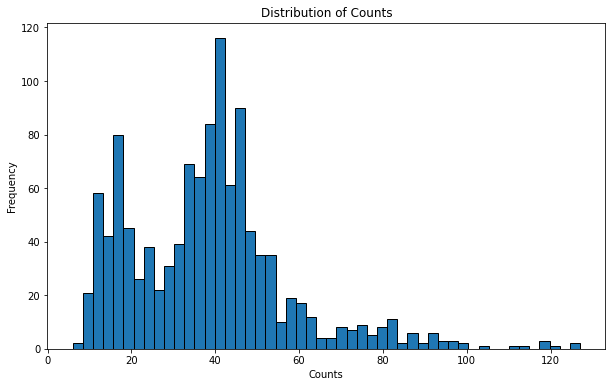

In [114]:
# 기본 통계 요약
print(datewise_counts.describe())

# 히스토그램
plt.figure(figsize=(10, 6))
datewise_counts.hist(bins=50, edgecolor='black')
plt.title("Distribution of Counts")
plt.xlabel("Counts")
plt.ylabel("Frequency")
plt.grid(False)
plt.show()

In [116]:
data_first_half.to_csv('eng_part1.csv', encoding='utf-8-sig', index=False)